# Batch Normalization

本文主要参考以下文档简单了解BN的基本原理。

- [A Gentle Introduction to Batch Normalization for Deep Neural Networks](https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/)
- [Batch normalization in 3 levels of understanding](https://towardsdatascience.com/batch-normalization-in-3-levels-of-understanding-14c2da90a338)

训练具有数十层的深度神经网络具有挑战性，因为它们可能对学习算法的初始随机权重和配置敏感。

造成这种困难的一个可能原因是，当权重更新时，在每个minibatch之后，网络深层的输入分布可能会发生变化。这会导致学习算法永远追逐移动目标。网络中各层输入分布的这种变化被称为“internal covariate shift”这一技术术语。

Batch Normalization批量归一化（BN）是一种用于训练非常深的神经网络的技术，它对每个小批量的层的输入进行标准化。这具有稳定学习过程并显著减少训练深度网络所需的训练周期数的效果。

现代DNN框架都已经实现了 BN，并且将它当作一个module来使用，很容易地插入DNN作为一个单独层。

## 训练深度网络的问题

训练深度神经网络，例如具有数十个隐藏层的网络，具有挑战性。

这一挑战的一个方面是，模型从输出到输入逐层反向更新，误差估计中使用的梯度是在假设当前层之前的层中的权重是固定的条件下来告诉我们如何更新参数的。

因为在更新过程中所有层都发生了变化，所以更新过程永远在追逐一个在不断变化的目标。

例如，假设前一层输出具有给定分布的值，则更新层的权重。在更新前一层的权重后，这种分布可能会发生变化。

由于每层输入的分布在训练过程中随着前一层的参数的变化而发生变化，因此训练深度神经网络很复杂。由于需要较低的学习率和仔细的参数初始化，这会减慢训练速度，并且使得训练具有饱和非线性的模型变得非常困难。

介绍批量归一化的论文的作者将训练期间输入分布的变化称为Internal Covariate Shift “内部协变量偏移”。

> 我们将训练过程中深度网络内部节点分布的变化称为内部协变量偏移 -- [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167)

## 标准化层输入

批量归一化，或简称为batchnorm，被提议作为一种技术来帮助协调模型中多层的更新。

> 批量归一化提供了一种重新参数化几乎所有深度网络的优雅方式。重新参数化显著减少了跨多个层协调更新的问题 — [深度学习 Batch Normalization](https://www.deeplearningbook.org/contents/optimization.html)

它可以缩放层的输出，特别是通过标准化每个minibatch的每个输入变量的激活值，例如来自前一层的节点的激活。回想一下，标准化是指将数据重新缩放以使其均值为 0，标准差为 1，例如标准高斯。

批量归一化对模型进行重新参数化，使某些单位始终按照定义进行标准化。

当应用于计算机视觉中的图像时，这个过程也被称为“whitening” 白化。

通过对每一层的输入进行白化，我们将朝着实现输入的固定分布迈出一步，从而消除内部协变量移位的不良影响。

标准化前一层的激活意味着后续层在权重更新期间对输入的传播和分布所做的假设不会改变，至少不会显着改变。这具有稳定和加速深度神经网络的训练过程的效果。

批量归一化仅对每个单元的均值和方差进行标准化以稳定学习，但允许单元之间的关系和单个单元的非线性统计发生变化。

对层的输入进行归一化会对模型的训练产生影响，从而显着减少所需的 epoch 数。它还可以具有正则化效果，就像使用激活值正则化一样减少泛化误差。

批量归一化可以对优化性能产生巨大影响，特别是对于卷积网络和具有 sigmoidal 非线性的网络。

> BatchNorm 从根本上影响网络训练：它使相应优化问题的情况更加平滑。这尤其确保了梯度更具预测性，从而允许使用更大范围的学习率和更快的网络收敛 — [批量归一化如何帮助优化？（不，这与内部协变量偏移无关），2018 年](https://arxiv.org/abs/1805.11604)

## 如何标准化图层输入

批量归一化可以在训练期间通过计算每个minibatch的层的输入变量的平均值和标准偏差并使用这些统计数据来执行标准化以实现。

或者，可以跨minibatch保持均值和标准差的运行平均值，但可能会导致训练不稳定。

> 很自然地会问，我们是否可以简单地使用移动平均值 在训练期间执行归一化 。然而，据观察，这会导致模型爆炸 — [批量重新归一化：在批量归一化模型中减少小批量依赖，2017 年](https://arxiv.org/abs/1702.03275)

训练和测试阶段的BN计算是不同的。

训练阶段，BN执行以下变换：

![](img/1_1VLh4r5ljTITW9h-E-Bamw.gif)

![](img/1_89JEFNiKgg16hPtBY25YdQ.gif)

BN层首先使用（1）和（2）确定batch的激活值的均值和标准差。然后，执行式（3），这一batch内神经元输出遵循标准正态分布，其中$\epsilon$是一个用于数值稳定的常量。

![](img/1_TrjyZmHj_wInh6kFARuLZw.jpeg)

最后用式（4），作用一个有$\gamma$和$\beta$线性变换，$\gamma$和$\beta$是可以训练的两个参数。通过调整这两个参数，这步允许模型为每层选择最优分布。

- 𝛾 允许调整标准差；
- 𝛽 允许调整偏差，即左移或右移曲线.

![](img/1_zEkSLa9rpfEmINn5DmJbOA.jpeg)

上图表示，改变分布(上面的子图)允许我们使用非线性函数的不同区域(下面子图)。

在每次迭代中，网络计算与当前batch对应的均值 𝜇 和标准差 σ。然后它通过梯度下降训练𝛾和𝛽，使用指数滑动平均线(EMA)来更加重视最新的迭代。

不像训练阶段，测试阶段我们没有整个batch来给到模型。为了处理这个问题，训练后，层输入的均值和标准差可以设置为在训练数据集上观察到的平均值，计算 𝜇_pop , σ_pop：

- 𝜇_pop: 研究总体的估计均值;
- σ_pop : 研究总体的估计标准差.

这些值是使用训练期间确定的所有 (𝜇_batch , σ_batch) 计算得出的，并在测试期间直接输入方程 (3)（而不调用 (1) 和 (2)）。

具体实践中，我们可以直接将batch normalization当作一个标准层就行了，就像一个卷积层，一个激活函数层一样。Pytorch和Tensorflow都有这样的实现。所有的BN实现允许独立地设置参数，但是输入向量地大小是要特别注意的。它需要设置为：

- 当前隐藏层中有多少神经元（对于 MLP）；
- 当前隐藏层中有多少过滤器（对于卷积网络）。

即使我们不懂 BN，我们也能知道BN层会使得 训练更快，允许更广范围的学习率依然能在训练中收敛。

下面是具体的实现示例以及更多解释。

## 进一步理解BN

In [1]:
# Hypeparameters

LR_BASE = 0.01 #lr baseline
LR_BN = 0.01 #lr bn network

num_iterations = 10000 #50000
valid_steps = 50 # training iterations before validation

verbose = True

In [2]:
# Libs
import numpy as np
import torch
from torch import nn
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Seeds
torch.manual_seed(0)
np.random.seed(0)

In [3]:
# Import the MINST dataset

transform_imgs = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize( # Not mentionned in the paper. No normalization
                                 (0.1307,), (0.3081,))])         # emphasizes the smoothing effect on hidden layers
                                                                 # activation.

mnist_trainset = datasets.MNIST(root='./data', 
                                train=True, 
                                download=True, 
                                transform=transform_imgs)

mnist_testset = datasets.MNIST(root='./data', 
                               train=False, 
                               download=True, 
                               transform=transform_imgs)

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw

Processing...
Done!


In [4]:
## Dataset loader


train_loader_params = {'shuffle': True, 'batch_size' : 60, 'drop_last' : False}
test_loader_params = {'shuffle': False, 'batch_size' : 60, 'drop_last' : False}

train_loader = DataLoader(mnist_trainset, **train_loader_params )
test_loader = DataLoader(mnist_testset, **test_loader_params )

# Each batch : (imgs, targets)
#    imgs : (batch_size=60, channels=1, height=28, width=28) tensor (float32)
#    targets : (batch_size=60) tensor (int64)

In [5]:
## BatchNorm reimplementation

class myBatchNorm2d(nn.Module):
    def __init__(self, input_size = None , epsilon = 1e-3, momentum = 0.99):
        super(myBatchNorm2d, self).__init__()
        assert input_size, print('Missing input_size parameter.')
        
        # Batch mean & var must be defined during training
        self.mu = torch.zeros(1, input_size)
        self.var = torch.ones(1, input_size)
        
        # For numerical stability
        self.epsilon = epsilon
        
        # Exponential moving average for mu & var update 
        self.it_call = 0  # training iterations
        self.momentum = momentum # EMA smoothing
        
        # Trainable parameters
        self.beta = torch.nn.Parameter(torch.zeros(1, input_size))
        self.gamma = torch.nn.Parameter(torch.ones(1, input_size))
        
        # Batch size on which the normalization is computed
        self.batch_size = 0

        
    def forward(self, x):
        # [batch_size, input_size]
        
        self.it_call += 1
        
        if self.training :
            
            if self.batch_size == 0:
                # First iteration : save batch_size
                self.batch_size = x.shape[0]
            
            # Training : compute BN pass
            batch_mu = (x.sum(dim=0)/x.shape[0]).unsqueeze(0) # [1, input_size]
            batch_var = (x.var(dim=0)/x.shape[0]).unsqueeze(0) # [1, input_size]
            
            x_normalized = (x-batch_mu)/torch.sqrt(batch_var + self.epsilon) # [batch_size, input_size]
            x_bn = self.gamma * x_normalized + self.beta # [batch_size, input_size]
            
            
            # Update mu & std 
            if(x.shape[0] == self.batch_size):
                running_mu = batch_mu
                running_var = batch_var
            else:
                running_mu = batch_mu*self.batch_size/x.shape[0]
                running_var = batch_var*self.batch_size/x.shape[0]
 
            self.mu = running_mu * (self.momentum/self.it_call) + \
                            self.mu * (1 - (self.momentum/self.it_call))
            self.var = running_var * (self.momentum/self.it_call) + \
                        self.var * (1 - (self.momentum/self.it_call))
            
        else:
            # Inference : compute BN pass using estimated mu & var
            if (x.shape[0] == self.batch_size):
                estimated_mu = self.mu
                estimated_var = self.var
            else :
                estimated_mu = self.mu*x.shape[0]/self.batch_size
                estimated_var = self.var*x.shape[0]/self.batch_size
                
            x_normalized = (x-estimated_mu)/torch.sqrt(estimated_var + self.epsilon) # [batch_size, input_size]
            x_bn = self.gamma * x_normalized + self.beta # [batch_size, input_size]
    
        return x_bn # [batch_size, output_size=input_size]

In [6]:
class ActivationTracker(nn.Module):
    '''Identity module, which keep track of the current activation during validation.'''
    
    def __init__(self):
        super(ActivationTracker, self).__init__()

        # Keep tack of [0.15, 0.5, 0.85] percentiles
        self.percents_activation_track = [15, 50, 85]
        self.all_percents_activation = []

    def get_all_activations(self):
        return np.array(self.all_percents_activation)
        
    def forward(self, x):
        
        if not self.training :
            percents_activation = np.percentile(x.detach().flatten(), self.percents_activation_track)
            self.all_percents_activation.append(percents_activation)
            #print('percents_activation = ', percents_activation)
        
        return x

In [7]:
## Networks

def init_weights(model):
    for module in model:
        if type(module) == nn.Linear:
            torch.nn.init.normal_(module.weight, mean=0.0, std=1.0) # "Random Gaussian value"
            #torch.nn.init.xavier_uniform_(module.weight)
            module.bias.data.fill_(0.)


input_size = 784

# Baseline
baseline_model = nn.Sequential(nn.Linear(input_size,100), #1
                      nn.Sigmoid(),
                      nn.Linear(100,100), #2
                      nn.Sigmoid(),
                      nn.Linear(100,100), #3
                      ActivationTracker(),
                      nn.Sigmoid(),
                      nn.Linear(100,10) # out
                     )

init_weights(baseline_model)


        
# BN model
bn_model = nn.Sequential(nn.Linear(input_size,100), #1
                      myBatchNorm2d(100),
                      nn.Sigmoid(),
                      nn.Linear(100,100), #2
                      myBatchNorm2d(100),
                      nn.Sigmoid(),
                      nn.Linear(100,100), #3
                      myBatchNorm2d(100),
                      ActivationTracker(),
                      nn.Sigmoid(),
                      nn.Linear(100,10) # out
                     )

init_weights(bn_model)

In [8]:
# Loss & metrics
criterion = nn.CrossEntropyLoss()
metric = accuracy_score

In [9]:
def valid_loop(model, valid_loader, criterion, metric, epoch, verbose = True):
    
    sum_loss = 0
    sum_score = 0
    
    for it, (imgs, targets) in enumerate(valid_loader, start=1):
        imgs = imgs.view(-1,784)
        
        with torch.no_grad():
            out = model(imgs) # [batch_size,num_class]
            preds  = torch.argmax(out.detach(), dim=1) # [batch_size]

            loss = criterion(out,targets)
            score = metric(targets, preds)

                    
            sum_loss += loss
            sum_score += score
            
    return sum_score/it, sum_loss/it

In [10]:
## Training models

def train_loop(model, train_loader, valid_loader, optimizer, scheduler, criterion, metric, verbose = True):

    # Loss & metric lists
    valid_stats = []
    epochs_valid_stats = []

    with tqdm(range(num_epochs), desc = "Train epochs") as epochs_bar :
        for e in epochs_bar:
          
          # Training
            with tqdm(train_loader, leave=False) as it_bar:
                for it, (imgs, targets) in enumerate(it_bar, start=1):
                    imgs = imgs.view(-1,784)

                    out = model(imgs) # [batch_size,num_class]
                    preds  = torch.argmax(out.detach(), dim=1) # [batch_size]

                    loss = criterion(out,targets)
                    score = metric(targets, preds)

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    if(it % valid_steps == 0):
                        # Validation
                        model.eval()
                        valid_score, valid_loss = valid_loop(model, valid_loader, criterion, metric, e, verbose)
                        valid_stats.append([valid_score.astype(np.float32), \
                                        valid_loss.detach().numpy().astype(np.float32)])
                        epochs_valid_stats.append(it+e*len(train_loader))
                    
                        if(verbose):
                            it_bar.set_postfix(valid_loss=valid_loss.item(), valid_score=valid_score)

                        model.train()
    
                scheduler.step()
    return np.array(valid_stats), epochs_valid_stats



def init_optim_and_scheduler(model, lr = 0.1):
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9) # momentum not mentioned
    #optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10) # Not mentioned in the paper
    return optimizer, scheduler

#---------------------------
# Training loops
#---------------------------

num_epochs = int(num_iterations/len(train_loader))


## Without BN
print('-'*15, 'BASELINE MODEL', '-'*15)
optimizer, scheduler = init_optim_and_scheduler(baseline_model, lr = LR_BASE)
valid_stats_base, epochs_stats = train_loop(baseline_model, train_loader, test_loader, \
                                            optimizer, scheduler, criterion, metric, verbose = verbose)

## With BN
print('-'*15, 'BATCH NORMALIZED MODEL', '-'*15)
optimizer, scheduler = init_optim_and_scheduler(bn_model, lr = LR_BN)
valid_stats_bn, epochs_stats = train_loop(bn_model, train_loader, test_loader, \
                                          optimizer, scheduler, criterion, metric, verbose = verbose)

--------------- BASELINE MODEL ---------------


Train epochs:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

--------------- BATCH NORMALIZED MODEL ---------------


Train epochs:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

训练时间比较长，需要耐心等待。

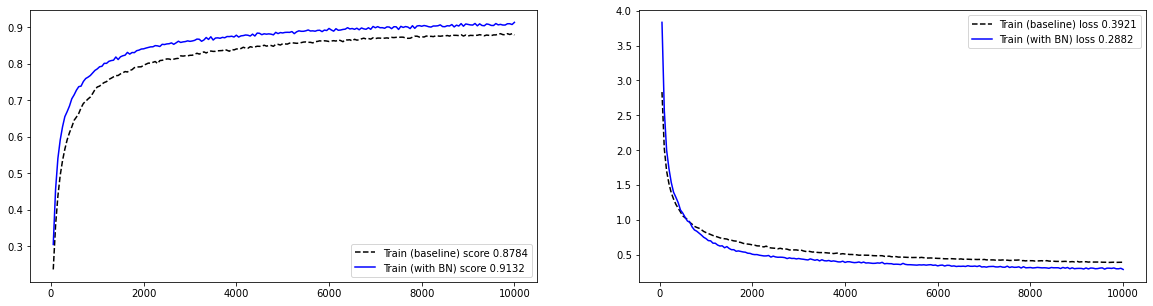

In [11]:
if epochs_stats: 
    fig, ax = plt.subplots(1, 2, figsize=(10*2, 5))
    #ax.clear()
    
    # Scores
    ax[0].plot(epochs_stats, valid_stats_base[:, 0], 'k--', \
               label = f"Train (baseline) score {valid_stats_base[-1, 0]:.4f}")
    ax[0].plot(epochs_stats, valid_stats_bn[:, 0], 'b-', \
               label = f"Train (with BN) score {valid_stats_bn[-1, 0]:.4f}")
    
    # Losses
    ax[1].plot(epochs_stats, valid_stats_base[:, 1], 'k--', \
               label = f"Train (baseline) loss {valid_stats_base[-1, 1]:.4f}")
    ax[1].plot(epochs_stats, valid_stats_bn[:, 1], 'b-', \
               label = f"Train (with BN) loss {valid_stats_bn[-1, 1]:.4f}")
    
    ax[0].legend(); ax[1].legend()
    plt.show()

[官方文章](https://arxiv.org/abs/1502.03167)进行了3次实验来展示他们的方法有效性。上面的结果对应第一个实验。

在 MNIST 数据集（手写数字）上训练了一个分类器。该模型由 3 个完全连接的层组成，每个层有 100 个神经元，全部由 sigmoid 函数激活。使用随机梯度下降 (SGD) 和相同的学习率 (0.01) 对这个模型进行了两次训练（有和没有 BN 层）进行了 10 000 次迭代。请注意，BN 层被放置在激活函数之前。

上面我们在没有 GPU 的情况下轻松重现了这些结果。

看起来不错 ！Batch Normalization 提高了网络性能，包括损失和准确性。

第二个实验包括查看隐藏层中的激活值。以下是对应于最后一个隐藏层的图（就在非线性之前）：

In [12]:
# Get last hidden layer activation
baseline_activation = baseline_model[5].get_all_activations()
bn_activation = bn_model[8].get_all_activations()

# Reshape from [num_call_valid_bn,3] to [num_call_valid, num_test_batches, 3]
num_call_valid = len(epochs_stats)
num_test_batches = len(test_loader)
baseline_activation = np.reshape(baseline_activation, (num_call_valid,num_test_batches,3))
bn_activation = np.reshape(bn_activation, (num_call_valid,num_test_batches,3))

# Get mean over all the test batches
baseline_activation = np.mean(baseline_activation, axis=1)
bn_activation = np.mean(bn_activation, axis=1)

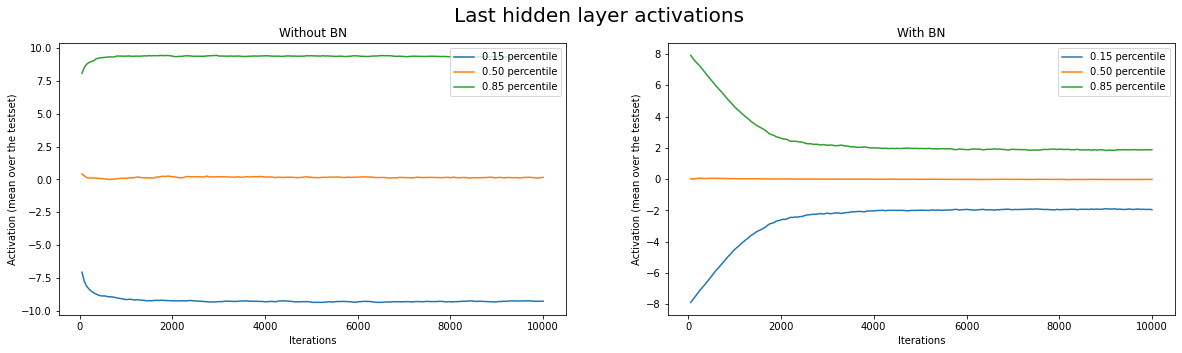

In [13]:
# Display activations
if epochs_stats: 
    fig, ax = plt.subplots(1, 2, figsize=(10*2, 5))

    # -- All iterations
    # Baseline
    ax[0].plot(epochs_stats, baseline_activation[:, 0], label = f"0.15 percentile")
    ax[0].plot(epochs_stats, baseline_activation[:, 1], label = f"0.50 percentile")
    ax[0].plot(epochs_stats, baseline_activation[:, 2], label = f"0.85 percentile")
    ax[0].set_title('Without BN')
    ax[0].set_xlabel('Iterations')
    ax[0].set_ylabel('Activation (mean over the testset)')
    
    # BN based
    ax[1].plot(epochs_stats, bn_activation[:, 0], label = f"0.15 percentile")
    ax[1].plot(epochs_stats, bn_activation[:, 1], label = f"0.50 percentile")
    ax[1].plot(epochs_stats, bn_activation[:, 2], label = f"0.85 percentile")
    ax[1].set_title('With BN')
    ax[1].set_xlabel('Iterations')
    ax[1].set_ylabel('Activation (mean over the testset)')
    
    ax[0].legend(); ax[1].legend()
    plt.suptitle('Last hidden layer activations', fontsize=20)
    plt.show()

在没有批量标准化的情况下，激活值在第一次迭代期间波动很大。相反，当使用 BN 时，激活曲线更平滑。

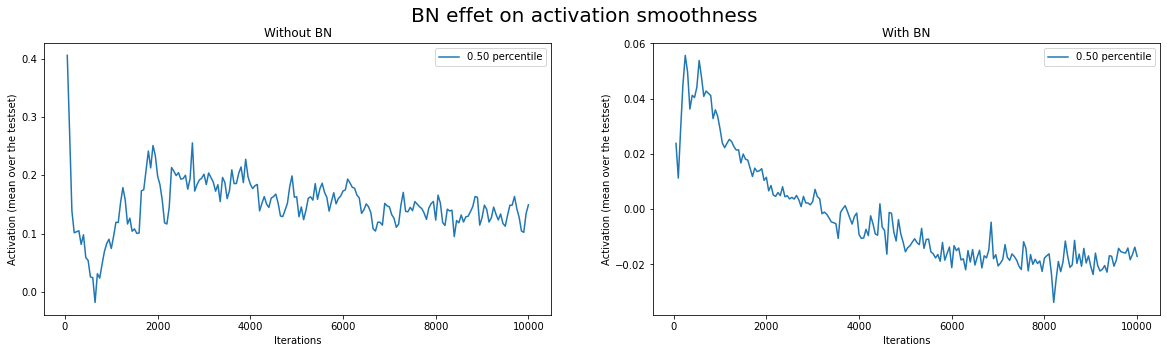

In [14]:
# -- Smallest window to visualize smoothing effect
small_window = 250

if epochs_stats: 
    fig, ax = plt.subplots(1, 2, figsize=(10*2, 5))

    # Baseline
    ax[0].plot(epochs_stats[:small_window], baseline_activation[:small_window, 1], label = f"0.50 percentile")
#    ax[0].set_xlim(100, 500)
#    ax[0].set_ylim(-10, -6)
    ax[0].set_title('Without BN')
    ax[0].set_xlabel('Iterations')
    ax[0].set_ylabel('Activation (mean over the testset)')
    
    # BN based
    ax[1].plot(epochs_stats[:small_window], bn_activation[:small_window, 1], label = f"0.50 percentile")
#    ax[1].set_xlim(100, 500)
#    ax[1].set_ylim(-2, 2)
    ax[1].set_title('With BN')
    ax[1].set_xlabel('Iterations')
    ax[1].set_ylabel('Activation (mean over the testset)')
    
    ax[0].legend(); ax[1].legend()
    plt.suptitle('BN effet on activation smoothness', fontsize=20)
    plt.show()

此外，当添加 BN 层时，信号噪声较小。它似乎使模型的收敛更容易。

这里给出的例子没有展示批量标准化的所有好处。

官方文章进行了第三次实验。他们想在更大的数据集上添加 BN 层时比较模型性能：ImageNet (2012)。为此，他们训练了一个当时强大的神经网络，称为 Inception 。最初，这个网络没有任何 BN 层。他们添加了一些，并通过修改其学习率（x1、x5、x30 以前的最佳值）来训练模型。他们还尝试用另一个网络中的 sigmoid 替换每个 ReLU 激活函数。然后，他们将这些新网络的性能与原始网络的性能进行了比较。

![](img/1_gfzbC-GrOoVUfk1yU4DdfQ.png)

我们可以从这些曲线中得出结论：

- 添加 BN 层会导致更快更好的收敛（其中更好意味着更高的准确性）；在如此大的数据集上，这种改进比在小型 MNIST 数据集上观察到的改进要显着得多。
- 添加 BN 层允许我们在不影响收敛性的情况下使用更高的学习率 (LR)；作者使用比原始网络高 30 倍的学习率成功地训练了他们的 Inception-with-BN 网络。请注意，大 5 倍的 LR 已经使普通网络发散了！

这样，找到“可接受”的学习率就容易多了：LR 介于欠拟合和梯度爆炸之间的间隔要大得多。

此外，更高的学习率有助于优化器避免局部最小值收敛。鼓励探索，优化器将更容易收敛到更好的解决方案。

基于sigmoid 的模型 与基于 ReLU 的模型取得了有竞争力的结果

我们需要退后一步，放眼大局。我们可以清楚地看到，使用基于 ReLU 的模型可以获得比使用 sigmoid 模型稍好一些的性能，但这在这里并不重要。

为了说明为什么这个结果是有意义的，重新表述一下 Ian Goodfellow（GANs 的发明者，著名的“深度学习”手册的作者）是怎么说的：

> 在 BN 之前，我们认为在隐藏层中使用 sigmoid 有效训练深度模型几乎是不可能的。我们考虑了几种解决训练不稳定的方法，例如寻找更好的初始化方法。这些解决方案非常具有启发性，而且太脆弱而无法令人满意。批量标准化使那些不稳定的网络可训练 ; 这就是这个例子所显示的 — Ian Goodfellow

现在我们明白了为什么 BN对深度学习领域产生了如此重要的影响。

这些结果概述了批量标准化对网络性能的好处。但是，为了充分利用 BN，还应该记住一些副作用。

###  Regularization, a BN side effect

BN 依赖batch的一阶矩、二阶矩（均值和方差）来正则化隐藏层激活。然后输出值与当前批次统计数据紧密相关。这种转换会增加一些噪音，具体取决于当前批次中使用的输入示例。

添加一些噪音以避免过度拟合……听起来像是一个正则化过程，不是吗？

在实践中，我们不应该依赖批量归一化来避免过拟合，因为正交性很重要。简而言之，我们应该始终确保一个模块解决一个问题。依靠多个模块来处理不同的问题使得开发过程比需要的要困难得多。

尽管如此，了解正则化效应还是很有趣的，因为它可以解释网络的一些意外行为（尤其是在健全性检查期间）。

备注：批量越大，正则化越小（因为它减少了噪音影响）。

再看测试/评估期间的归一化。

### Normalization during evaluation

有两种情况可以在测试模式下调用模型：

- 在进行交叉验证或测试时，在模型训练和开发过程中；
- 当部署模型时

在第一种情况下，为了方便起见，我们可以使用当前batch统计数据应用BN。

在第二个中，使用相同的方法没有意义，因为我们不一定有整个批次要预测。

让我们看一个带有嵌入式摄像头的机器人的例子。我们可以有一个模型，使用当前框架来预测任何即将到来的障碍物的位置。所以我们想在每次迭代的单个帧（即一个 rgb 图像）上计算推理。如果训练批次大小为 N，我们应该为模型期望的 (N-1) 个其他输入选择什么来进行前向传播？

请记住，对于每个 BN 层，( 𝛽 , 𝛾 ) 是使用归一化信号进行训练的。所以我们需要确定 (𝜇, σ)以获得有意义的结果。

这个技巧是定义( 𝜇_pop , σ_pop )，它们分别是目标总体的估计均值和标准差。这些参数被计算为所有训练期间确定的(𝜇_batch, σ_batch）的平均值。

备注：这个技巧在评估阶段可能会导致不稳定。

### BN layer stability

尽管批量标准化工作得很好，但它有时会导致稳定性问题。有些情况下，BN 层在评估阶段使激活值爆炸（使模型返回损失 = NaN）。

让我们考虑一个仅在包含运动鞋的图像上训练的模型。如果我们在测试集中有皮鞋怎么办？

如果输入分布从训练到评估变化太大，模型可能对某些信号反应过度，导致激活发散。

我们假设隐藏层的激活值在训练和评估期间会有显著不同的分布。在这种情况下，估计的 (𝜇_pop, σ_pop) 没有正确估计真实的总体均值和标准差。应用 (𝜇_pop, σ_pop) 可能会将激活值推离 (𝜇 = 0, σ = 1)，导致高估激活值。

备注：训练集和测试集之间分布的偏移称为“协变量偏移”。

BN 的一个众所周知的特性增加了这种效果：在训练期间，激活值使用它们自己的值进行归一化。在推理过程中，使用 (𝜇_pop, σ_pop)对信号进行归一化，这些是在训练期间计算的。因此，用于归一化的系数不考虑实际激活值本身。

一般来说，训练集必须与测试集“足够相似”：否则，就不可能在目标任务上正确训练模型。所以在大多数情况下，𝜇_pop 和σ_pop 应该很适合测试集。如果不是，我们可能会得出结论，训练集不够大，或者它的质量对于目标任务来说不够好。
但有时，它会发生。这个问题并没有一个彻底的解决方案。

当无法轻松获得额外数据来增强训练集时，必须想一些解决方法。所以向网络添加 BN 层——假设它不会产生负面影响——并不总是最好的策略！

### Recurrent network and Layer normalization

还有，在实践中，人们普遍承认：

- 对于卷积网络（CNN）：批量归一化（BN）更好
- 对于循环网络（RNN）：层归一化（LN）更好

BN 使用当前批次对每个值进行归一化，而 LN 使用所有当前层来执行此操作。换句话说，标准化是使用来自单个示例的其他特征执行的，而不是在所有当前批处理示例中使用相同的特征。对于循环网络，此解决方案似乎更有效。请注意，很难为这些类型的神经元定义一致的策略，因为它们依赖于多次乘法相同的权重矩阵。

###  Before or after the nonlinearity ?

从历史上看， BN 层位于非线性函数之前，这与作者当时的目标和假设一致：

在他们的文章中，他们说：

> “我们希望确保对于任何参数值，网络始终产生具有所需分布的激活。” — Sergey Ioffe 和 Christian Szegedy

一些实验表明，在非线性函数之后放置 BN 层会导致更好的结果。

Keras 的创造者、现任谷歌工程师 François Chollet 表示：
> “我没有回去检查他们在原始论文中的建议，但我可以保证最近由 Christian [Szegedy] 编写的代码在 BN 之前应用 relu。不过，这仍然偶尔会成为争论的话题。” — 弗朗索瓦·乔莱（François Chollet）

尽管如此，许多常用的迁移学习架构在非线性之前应用 BN（ResNet、mobilenet-v2 等）。

## Why does Batch Normalization work ?

在大多数情况下，批量归一化可以提高深度学习模型的性能。那太棒了。但我们想知道黑匣子内部实际发生了什么。

问题是：我们不知道到底是什么让批标准化工作这么好。DL 社区中经常讨论一些假设，我们将逐步探索它们。

原始论文假设BN有效性是由于减少了他们所说的内部协变量移位（ICS）。但最近的[一篇论文](https://arxiv.org/abs/1805.11604) 驳斥了这一假设。

另一个假设以更加谨慎的方式取代了第一个假设：BN在训练期间减轻了层之间的相互依赖性。

上面提到的最近的那篇论文强调了 BN 对优化景观平滑度的影响，使训练更容易。

探索这些假设将帮助我们建立对批量归一化的直觉。这里暂时不记录了，后续再补充。

## 使用批量归一化的技巧

### 使用不同的网络类型

批量归一化是一种通用技术，可用于将输入归一化为层。

它可以与大多数网络类型一起使用，例如多层感知器、卷积神经网络和循环神经网络。

### 在激活前使用

可以在前一层激活函数之前或之后对层的输入使用批量归一化。

如果对于像双曲正切和逻辑函数这样的 S 形函数，在激活函数之后可能更合适。

对于可能导致非高斯分布的激活，例如修正线性激活函数，这是大多数网络类型的现代默认值，在激活函数之前可能是合适的。

### 使用大学习率

使用批量归一化使网络在训练过程中更加稳定。

这可能需要使用比正常学习率大得多的学习率，这反过来可能会进一步加快学习过程。

### 对权重初始化不太敏感

深度神经网络对用于在训练前初始化权重的技术非常敏感。

批量归一化带来的训练稳定性可以使训练深度网络对权重初始化方法的选择不那么敏感。

### 替代数据准备

批量标准化可用于标准化具有不同尺度的原始输入变量。

如果为每个输入特征计算的均值和标准差是在小批量而不是整个训练数据集上计算的，那么批量大小必须足以代表每个变量的范围。

它可能不适合具有高度非高斯分布的数据的变量，在这种情况下，最好将数据缩放作为预处理步骤执行。

### 不要与 Dropout 一起使用

批量归一化提供了一些正则化效果，减少了泛化错误，也许不再需要使用dropout 进行正则化。

从 Modified BN-Inception 中删除 Dropout 可以加快训练速度，同时不会增加过拟合。

在同一网络中使用批量归一化和 dropout 可能不是一个好主意。

原因是由于在丢弃过程中随机丢弃节点，用于对前一层激活进行归一化的统计数据可能会变得嘈杂。

> 由于用于归一化每个变量的统计估计中的噪声，批量归一化有时还可以减少泛化误差并允许忽略 dropout — 第 425 页，深度学习，2016 年。